In [3]:
import numpy as np

from matplotlib import pyplot as plt

from astropy.io import fits

In [4]:
f = '/Users/josephwick/Documents/Data/merian/COSMOS2015_r23.6_SOM_v2.fits'

In [5]:
# load train data
# yifei's catalog with specz flag ('spec_z' == 1)
# We train on the spectroscopic subset of the entire, representative, catalog

# reading data from fits file
data=fits.open(f)[1].data
data = data[data['z_type']==1]

# extract flux
# we're using g,r,i,z,y band magnitudes
aphot_train = 10**(-0.4 * np.c_[data['a_g'], data['a_r'], data['a_i'], 
                                data['a_z'], data['a_y']])

phot_train = np.c_[data['g_cmodel_flux'], 
                   data['r_cmodel_flux'],
                   data['i_cmodel_flux'],
                   data['z_cmodel_flux'],
                   data['y_cmodel_flux']] / aphot_train

err_train = np.c_[data['g_cmodel_flux_err'], 
                  data['r_cmodel_flux_err'], 
                  data['i_cmodel_flux_err'],
                  data['z_cmodel_flux_err'],
                  data['y_cmodel_flux_err']] / aphot_train

rMags_spec = data['r_cmodel_mag']

mask_train = (err_train > 0.) & np.isfinite(err_train) & np.isfinite(phot_train)

# remove any sources with non-detections
sel = mask_train.sum(axis=1) == 5
phot_train, err_train, mask_train = phot_train[sel], err_train[sel], mask_train[sel]
rMags_spec = rMags_spec[sel]

In [6]:
# load calib data
# yifei's catalog, representative
# we want to calibrate the specz subset to the representative catalog

data=fits.open(f)[1].data

aphot_calib = 10**(-0.4 * np.c_[data['a_g'], data['a_r'], data['a_i'], 
                                data['a_z'], data['a_y']])

phot_calib = np.c_[data['g_cmodel_flux'],
                   data['r_cmodel_flux'],
                   data['i_cmodel_flux'],
                   data['z_cmodel_flux'],
                   data['y_cmodel_flux']] / aphot_calib

err_calib = np.c_[data['g_cmodel_flux_err'],
                  data['r_cmodel_flux_err'],
                  data['i_cmodel_flux_err'],
                  data['z_cmodel_flux_err'],
                  data['y_cmodel_flux_err']] / aphot_calib

rMags = data['r_cmodel_mag']

mask_calib = (err_calib > 0.) & np.isfinite(err_calib) & np.isfinite(phot_calib)

# remove any sources with non-detections
sel2 = mask_calib.sum(axis=1) == 5
phot_calib, err_calib, mask_calib = phot_calib[sel2], err_calib[sel2], mask_calib[sel2]
rMags = rMags[sel2]

In [7]:
skynoise = np.median(err_calib, axis=0)
# josh used the calibration set for this

zeropoint = 10**(-0.4 * 48.6)
# unsure where these values come from
# = 3.6e-20

# Hist of magnitude space - all vs specz

In [18]:
phot_calib_t = np.array(phot_calib).T
phot_train_t = np.array(phot_train).T

Text(5.2, 10000, 'Y BAND')

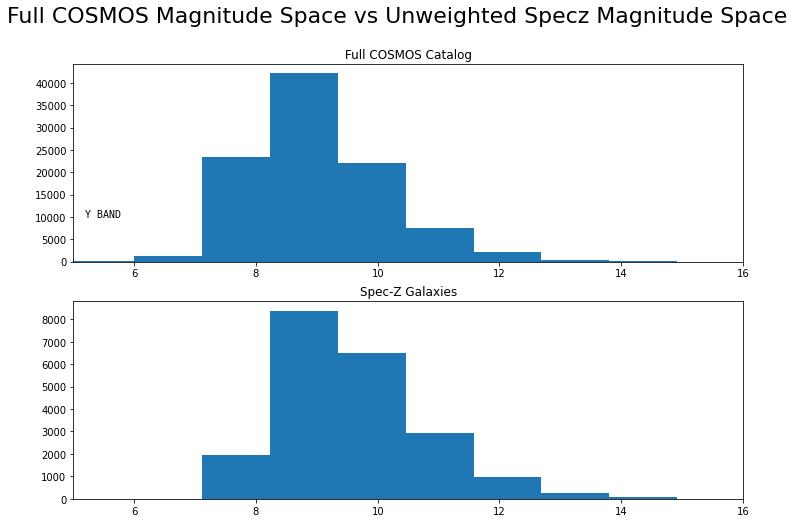

In [105]:
fig, axs = plt.subplots(2,1, figsize=(12,8))

band=4
bands = ['G', 'R', 'I', 'Z', 'Y']

nbin = 20

_,b,_ = axs[0].hist(np.log(phot_calib_t[band]), nbin)
axs[0].set_xlim([5,16])

axs[1].hist(np.log(phot_train_t[band]), bins=b)
axs[1].set_xlim([5,16])

# prettify 
plt.suptitle('Full COSMOS Magnitude Space vs Unweighted Specz Magnitude Space', fontsize=22)
axs[0].title.set_text('Full COSMOS Catalog')
axs[1].title.set_text('Spec-Z Galaxies')

axs[0].text(5.2, 10000, (bands[band] + ' BAND'), fontfamily='monospace')

# Apply weights

In [106]:
wts = np.load('specz-weights.npy')

In [107]:
phot_train_wtd = []
for i,g in enumerate(phot_train):
    g_wtd = []
    for m in g:
        g_wtd.append(wts[i] * m)
    phot_train_wtd.append(g_wtd)

phot_train_wtd_t = np.array(phot_train_wtd).T

Text(5.2, 10000, 'Y BAND')

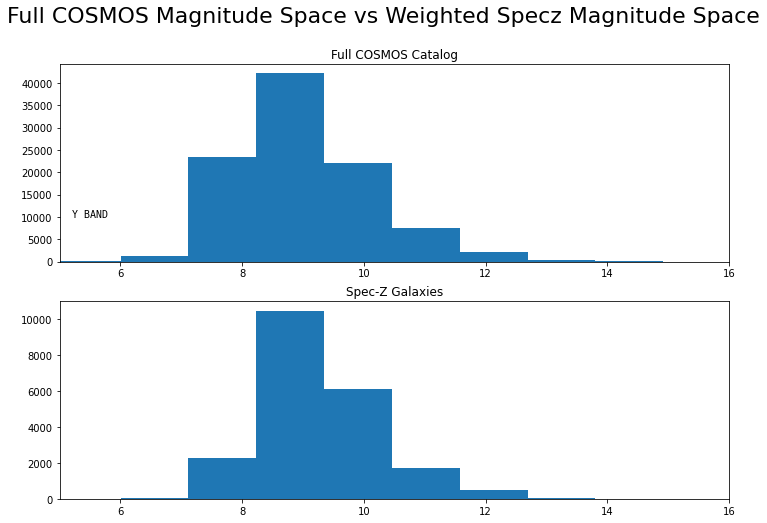

In [108]:
fig, axs = plt.subplots(2,1, figsize=(12,8))

_,b,_ = axs[0].hist(np.log(phot_calib_t[band]), nbin)
axs[0].set_xlim([5,16])

axs[1].hist(np.log(phot_train_wtd_t[band]), bins=b)
axs[1].set_xlim([5,16])

# prettify 
plt.suptitle('Full COSMOS Magnitude Space vs Weighted Specz Magnitude Space', fontsize=22)
axs[0].title.set_text('Full COSMOS Catalog')
axs[1].title.set_text('Spec-Z Galaxies')

axs[0].text(5.2, 10000, (bands[band] + ' BAND'), fontfamily='monospace')